In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_1st
cluster = cluster_1st

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

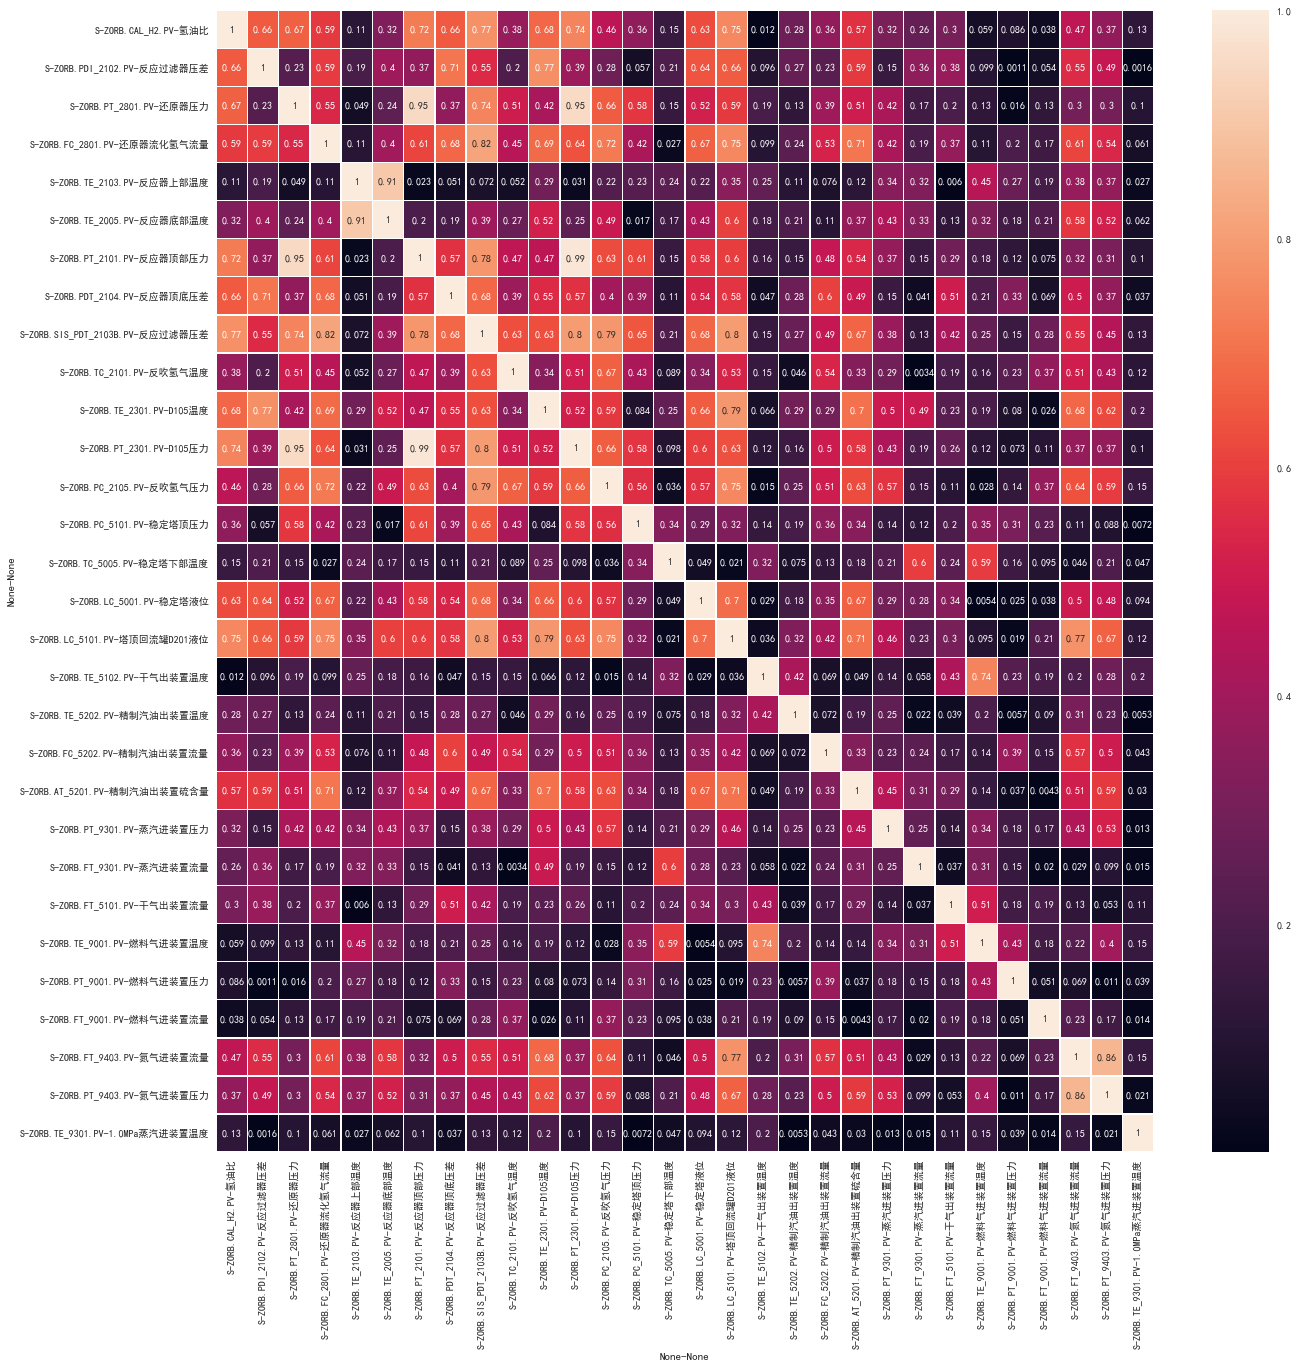

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 315 columns to remove.


In [6]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.TE_2103.PV,S-ZORB.TC_5005.PV,S-ZORB.TE_5102.PV,S-ZORB.FT_9001.PV,S-ZORB.TE_9301.PV,S-ZORB.LC_1201.PV,S-ZORB.PC_2601.PV,S-ZORB.TC_2607.PV,S-ZORB.FT_1204.PV,S-ZORB.LI_9102.DACA,S-ZORB.LC_3301.DACA,S-ZORB.LC_1203.DACA,S-ZORB.LT_2901.DACA,S-ZORB.LT_1002.DACA,S-ZORB.FT_3501.DACA,S-ZORB.PC_3001.DACA,S-ZORB.PDT_3602.DACA,S-ZORB.FT_1301.DACA,cluster
,氢油比,反应器上部温度,稳定塔下部温度,干气出装置温度,燃料气进装置流量,1.0MPa蒸汽进装置温度,D104液面,再生器压力,再生器温度,0,D-204液位,D123冷凝水罐液位,D-121水液位,D-109吸附剂料位,D-101脱水包液位,循环氢至闭锁料斗料腿流量,D-113压力,冷氮气过滤器ME-114差压,K-103出口去K-101出口管流量,
305,0.275087,420.961348,129.351743,33.520163,439.088540,200.838835,49.991111,0.110208,488.732063,58.892811,45.635215,51.424337,45.000710,34.130246,-4.971108,-0.179180,0.050032,0.348048,904.452595,1
304,0.256952,422.196638,128.944752,31.103516,458.888505,201.778408,50.012023,0.110670,492.955478,46.054013,49.315489,49.912188,44.975760,38.593968,-4.967947,-0.018946,0.050016,0.257477,862.054798,1
299,0.258423,422.271200,128.704058,30.655869,444.876875,202.504448,50.011382,0.109804,497.615898,58.109264,63.240493,50.419132,44.930244,36.175264,-4.970005,-0.018842,0.049972,0.284306,1184.864393,1
297,0.255122,425.331228,131.869893,31.026107,477.114013,195.836760,50.005315,0.110177,501.973607,196.901288,45.589053,50.166068,40.301649,63.475207,-4.968253,-0.018045,0.050008,0.264850,2467.565825,1
294,0.259134,424.813462,129.576562,32.073875,466.505145,194.873130,49.995656,0.110163,501.805650,31.885711,44.337311,49.760661,40.032924,39.378435,-4.967697,-0.017890,0.050014,0.272785,920.723427,1


In [7]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(115, 7)
(115, 3)
(115, 20)


In [8]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [9]:
# Bootstrap Sampling
def bootstrap(data, size):
    return [random.choice(data) for _ in range(size)]

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
relate_features = set()
max_iter = 60
num_iter = 0
features_pool = list(set(manule_features.keys().to_numpy()))

while len(relate_features) <= int(len(features_pool)/3) and num_iter <= max_iter:
    choice_features = bootstrap(features_pool, int(manule_features.shape[1]/2))
    re_dimension = int(len(list(set(choice_features)))/3)
    tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
    X_tsne = tsne.fit_transform(manule_features[list(set(choice_features))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {len(list(set(choice_features)))}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 9. t-SNE降维后的数据维度 3
num_iter => 1 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 2 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 3 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 4 原始样本数据维度 10. t-SNE降维后的数据维度 3
num_iter => 5 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 6 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 7 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 8 原始样本数据维度 9. t-SNE降维后的数据维度 3
{('S-ZORB.LI_9102.DACA', 'D-204液位'), ('S-ZORB.LC_1201.PV', 'D104液面'), ('S-ZORB.PC_2601.PV', '再生器压力'), ('S-ZORB.LC_3301.DACA', 'D123冷凝水罐液位'), ('S-ZORB.LT_2901.DACA', 'D-109吸附剂料位'), ('S-ZORB.TE_9301.PV', '1.0MPa蒸汽进装置温度'), ('S-ZORB.CAL_H2.PV', '氢油比')}


In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.LI_9102.DACA,S-ZORB.LC_1201.PV,S-ZORB.PC_2601.PV,S-ZORB.LC_3301.DACA,S-ZORB.LT_2901.DACA,S-ZORB.TE_9301.PV,S-ZORB.CAL_H2.PV,原料性质,时间
,D-204液位,D104液面,再生器压力,D123冷凝水罐液位,D-109吸附剂料位,1.0MPa蒸汽进装置温度,氢油比,辛烷值RON,Unnamed: 1_level_1
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,1.150000e+02
mean,50.544743,50.003181,0.110134,49.964297,20.018738,200.483780,0.268157,0.864323,1.536351e+18
std,16.465977,0.069994,0.000434,0.666385,17.831791,12.093604,0.023494,0.522497,2.922241e+16
min,16.639936,49.433151,0.109395,47.173305,-0.012217,178.126682,0.227725,-0.144010,1.496218e+18
25%,38.236113,49.991212,0.109938,49.767346,2.732245,192.538277,0.249194,0.423301,1.509437e+18
50%,50.510727,50.004211,0.110031,50.001554,18.111762,199.515083,0.262866,0.763687,1.529654e+18
75%,62.671925,50.017908,0.110151,50.164579,35.388086,207.930270,0.291574,1.217535,1.558858e+18
max,84.812532,50.233993,0.111571,52.345715,63.475207,249.179738,0.306238,2.125231,1.590480e+18


In [12]:
weight_1st = manule_features.shape[0]/samples_features.shape[0]
model_features_1st = model_features
produc_features_1st = produc_features
%store model_features_1st
%store produc_features_1st
%store weight_1st

Stored 'model_features_1st' (DataFrame)
Stored 'produc_features_1st' (DataFrame)
Stored 'weight_1st' (float)
